# 楕円群のパーシステントホモロジー解析とトポロジー最適化

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
import plotly.graph_objs as go

In [3]:
from epencil import *

In [4]:
%matplotlib inline

In [5]:
rng = np.random.default_rng(seed=7777) # 20250224
# rng = np.random.default_rng(seed=777)
# rng = np.random.default_rng(seed=77)

radius = 0.6 # 基本ノイズ円の半径
alpha = 0.4 # 基本円のアスペクト比
num_points = 100 # 基本円の点数
near = 25
eps = 0.19 # ノイズ一様分布 [-eps, eps]
shape_clusters = (2, 3) # 基本円をこの列・行ならべる
max_iter = 3000
pd_hist_config = dict(colorbar=dict(type="log", colormap='viridis'))

## ローカルな共分散行列を用いた楕円 PH の検討

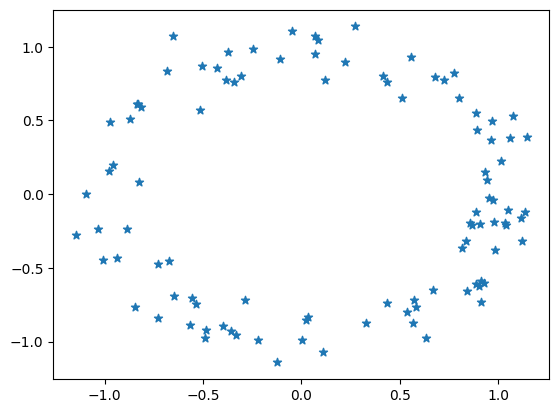

In [6]:
def unit_vector(theta):
    return numpy.array([numpy.cos(theta), numpy.sin(theta)])

theta = rng.uniform(0, 2 * np.pi, num_points)
noise = rng.uniform(-eps, eps, size=(2, num_points))
data = unit_vector(theta) + noise
plt.scatter(data[0], data[1], marker='*')

In [7]:
def stdform_from_cov(cov=[[1,0],[0,1]], scale=1):
    D, U = np.linalg.eig(cov)
    return (*np.sqrt(D), numpy.arctan2(*U[1, :]))

def abcdef_from_cov(x0=0, y0=0, cov=[[1,0],[0,1]]):
    r1, r2, theta = stdform_from_cov(cov=cov)
    return to_abcdef(x0, y0, r1, r2, theta)

def ellipse_curve_cov(x0=0, y0=0, cov=[[1,0],[0,1]], scale=1, N=100):
    """
    入力：
    中心 (x0, y0)
    共分散行列 cov
    媒介変数空間分割数 N
    出力：
    楕円の媒介変数表示 {'x': x, 'y': y}（Plotly plot に対応）
    """
    D, U = np.linalg.eig(cov)
    sqrtD = np.diag(np.sqrt(D))
    # 媒介変数
    t = np.linspace(0, 2 * np.pi, N)
    # 単位円→楕円のスケール回転平行移動変換を用いた媒介変数表示
    c = np.transpose([[x0, y0]])
    x, y = U @ (scale * sqrtD @ unit_vector(t)) + c
    return {'x': x, 'y': y}

def ellipse_patch(x0, y0, r1=1, r2=1, theta=0, *, cov=None, scale=1):
    if cov is not None:
        r1, r2, theta = stdform_from_cov(cov)
    ellipse = plt.matplotlib.patches.Ellipse(
        (x0, y0),
        width=2*r1*scale,
        height=2*r2*scale,
        angle=numpy.degrees(theta),
        edgecolor='black',
        facecolor='none',
        linestyle='-'
    )
    return ellipse

In [8]:
theta = rng.uniform(0, 2 * np.pi, num_points)
data = np.zeros((2, *shape_clusters, num_points))

circle = radius * unit_vector(theta)
circle[1] *= alpha
for i in range(shape_clusters[0]):
    for j in range(shape_clusters[1]):
        noise = rng.uniform(-eps, eps, size=(2, num_points))
        data[:, i, j] = circle + noise
        data[0, i, j] += j
        data[1, i, j] += i*alpha

data = data.reshape((2, -1))

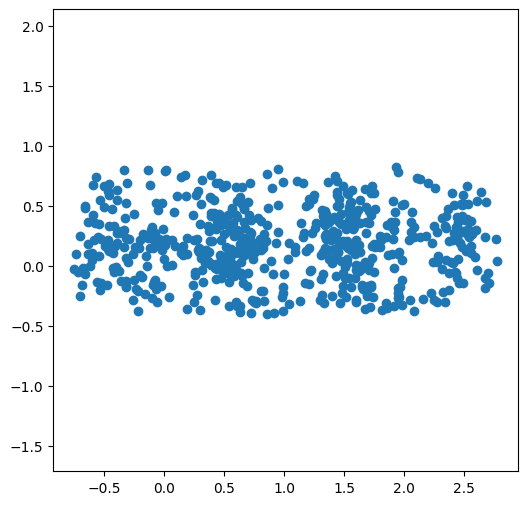

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*data, marker='o')
# ax.add_patch(ellipse_patch(*np.mean(data, axis=1), cov=np.cov(data)))
ax.set_aspect('equal', adjustable='datalim')
plt.show()

In [10]:
d = np.linalg.norm(data[:, None, :] - data[:, :, None], axis=0)
# argsort したものから :near だけとると重複が生じるので削る
np.argsort(d, axis=1).shape, np.unique(np.argsort(d, axis=1)[:, :near], axis=0).shape

((600, 600), (600, 25))

In [11]:
sorted_subsets = [tuple(sorted(subset))
                  for subset in np.unique(np.argsort(d, axis=1)[:, :near], axis=0)]  # 各サブセットをソートしてタプルに変換
unique_subsets = np.unique(sorted_subsets, axis=0)  # 重複を取り除く
unique_subsets.shape

(564, 25)

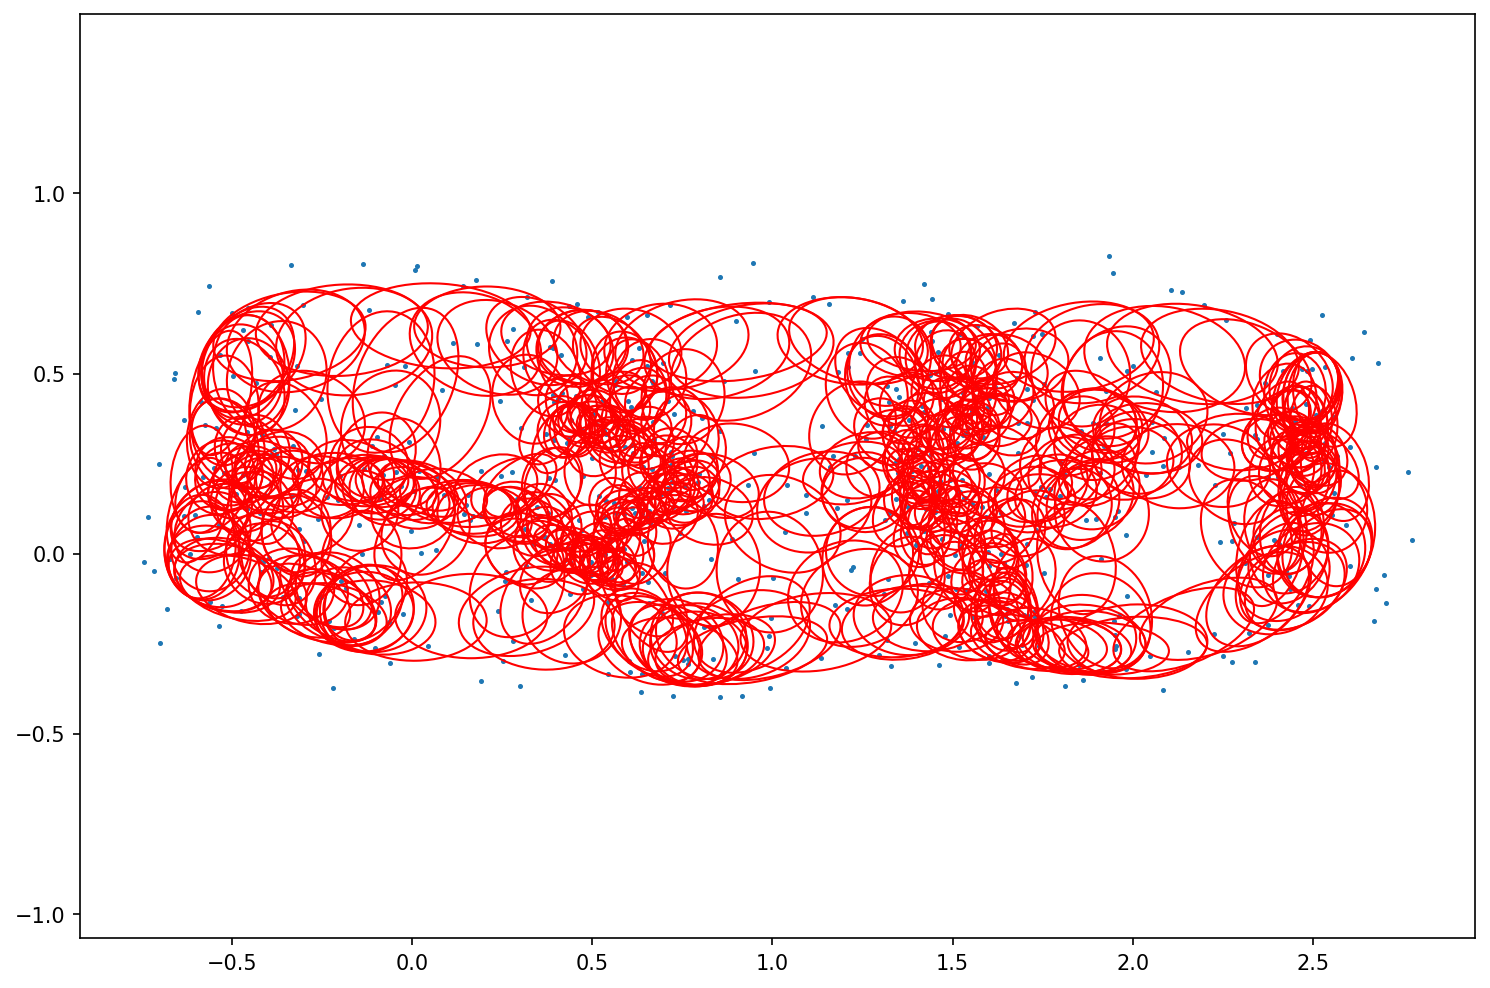

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=150)
ax.scatter(*data, s=2, marker='o')
ax.set_aspect('equal', adjustable='datalim')

ellipses = []

for near_indices in unique_subsets:
    near_data = data[:, near_indices]
    mean, cov = np.mean(near_data, axis=1), np.cov(near_data)
    e = abcdef_from_cov(*mean, cov)
    ellipses.append((e, mean, cov))
    p = ellipse_patch(*mean, cov=cov)
    p.set(edgecolor='red')
    ax.add_patch(p)

## スケールパラメタ $r$ によるフィルトレーションのパーシステントホモロジー

In [13]:
from itertools import combinations

allobjs = ellipses[:] # + ellipses_bd
num_objs = len(allobjs)
dist = np.zeros((num_objs, num_objs))
colliders = {}
for (i0, e0), (i1, e1) in combinations(enumerate(allobjs), 2):
    try:
        colliders[i0, i1] = colliders[i1, i0] = find_intersect(e0[0], e1[0])
        dist[i0, i1] = dist[i1, i0] = colliders[i0, i1][0]
    except Exception as e:
        print(i0, i1)
        print(e0)
        print(e1)
        print(numpy.array(e0) - numpy.array(e1))

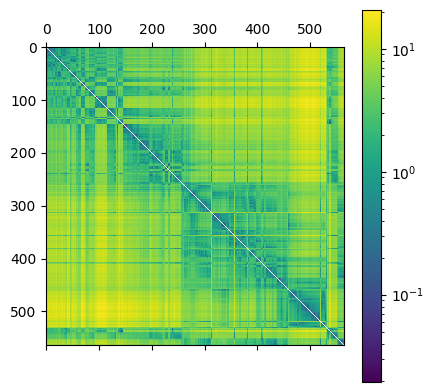

In [14]:
num_ellipses = len(allobjs)
plt.matshow(dist[:num_ellipses, :num_ellipses], norm='log')
plt.colorbar()

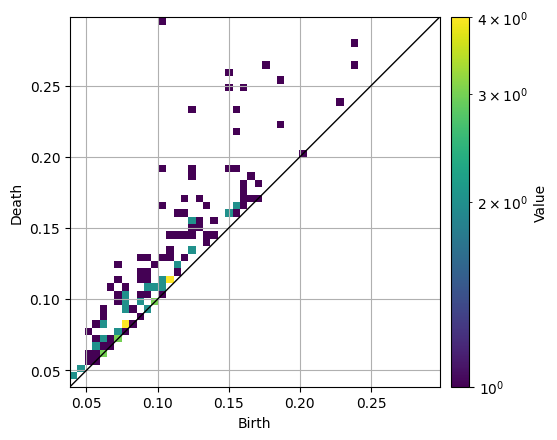

In [41]:
import homcloud.interface as hc
from scipy.spatial.distance import pdist, squareform

dist_orig = squareform(pdist(data.T))
hc.PDList.from_rips_filtration(dist_orig, maxdim=2, save_to="rips.pdgm", save_graph=True)
pdlist = hc.PDList("rips.pdgm")
pd1 = pdlist.dth_diagram(1)
pd1.histogram(x_bins=50).plot(**pd_hist_config)
plt.show()

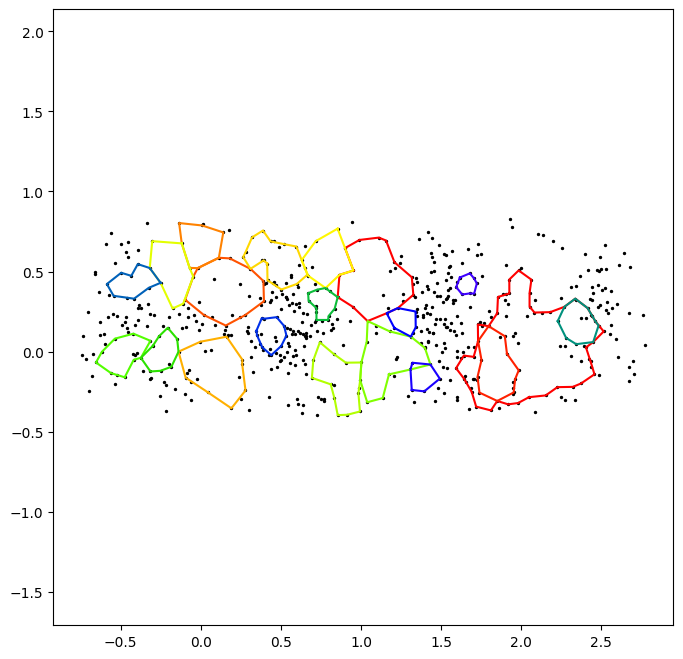

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(*data, s=2, marker='o', color='black')
ax.set_aspect('equal', adjustable='datalim')

take = 20
sorted_pairs = sorted(
    pd1.pairs(), reverse=True,
    key=lambda p: p.death_time() - p.birth_time())
for bd, color in zip(sorted_pairs[:take], cmap(numpy.arange(take))):
    opt1_cycle = bd.optimal_1_cycle()
    opt1_cycle_indices = opt1_cycle.boundary_points()
    lines = data[:, [*opt1_cycle_indices, opt1_cycle_indices[0]]]
    ax.plot(*lines, c=color)


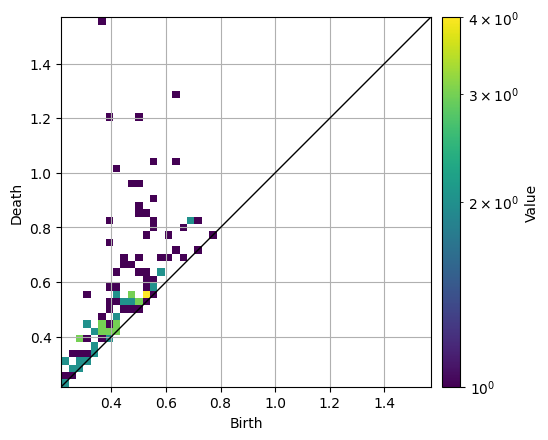

In [16]:
hc.PDList.from_rips_filtration(dist, maxdim=2, save_to="rips.pdgm", save_graph=True)
pdlist = hc.PDList("rips.pdgm")
pd1 = pdlist.dth_diagram(1)
pd1.histogram(x_bins=50).plot(**pd_hist_config)
plt.show()

In [17]:
# https://homcloud.dev/python-api/interface.html#homcloud.interface.Pair.optimal_1_cycle
bd = max(pd1.pairs(), key=lambda p: p.death_time())
optimal_1_cycle = bd.optimal_1_cycle()
bd, optimal_1_cycle.boundary_points()

(Pair(0.37510547041893005, 1.5706899166107178),
 [np.int64(442),
  475,
  499,
  496,
  489,
  483,
  520,
  523,
  527,
  474,
  468,
  469,
  461,
  460,
  458,
  339,
  333,
  328,
  326,
  320,
  315,
  353,
  354,
  355,
  348,
  347,
  370,
  371,
  369,
  364,
  363,
  362,
  383,
  365,
  398,
  399,
  402,
  413,
  441,
  438,
  np.int64(439)])

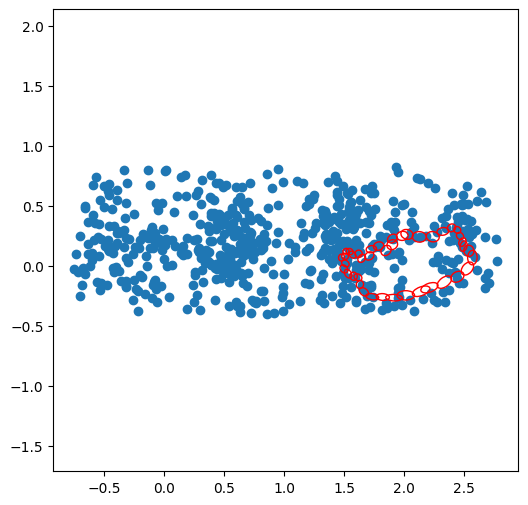

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*data, marker='o')
ax.set_aspect('equal', adjustable='datalim')

for near_indices in unique_subsets[optimal_1_cycle.boundary_points()]:
    near_data = data[:, near_indices]
    mean, cov = np.mean(near_data, axis=1), np.cov(near_data)
    e = abcdef_from_cov(*mean, cov)
    p = ellipse_patch(*mean, cov=cov, scale=bd.birth_time())
    p.set(edgecolor='red')
    ax.add_patch(p)

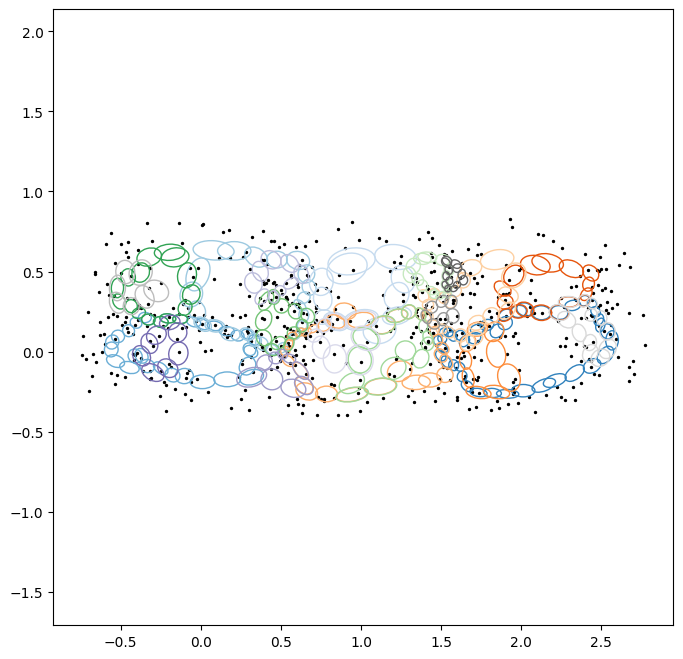

In [19]:
import matplotlib 
cmap = matplotlib.colormaps['tab20c']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(*data, s=2, marker='o', color='black')
ax.set_aspect('equal', adjustable='datalim')

take = 20
sorted_pairs = sorted(
    pd1.pairs(), reverse=True,
    key=lambda p: p.death_time() - p.birth_time())
for bd, color in zip(sorted_pairs[:take], cmap(numpy.arange(take))):
    opt1_cycle = bd.optimal_1_cycle()
    for near_indices in unique_subsets[opt1_cycle.boundary_points()]:
        near_data = data[:, near_indices]
        mean, cov = np.mean(near_data, axis=1), np.cov(near_data)
        e = abcdef_from_cov(*mean, cov)
        p = ellipse_patch(*mean, cov=cov, scale=bd.birth_time())
        p.set(edgecolor=color)
        ax.add_patch(p)

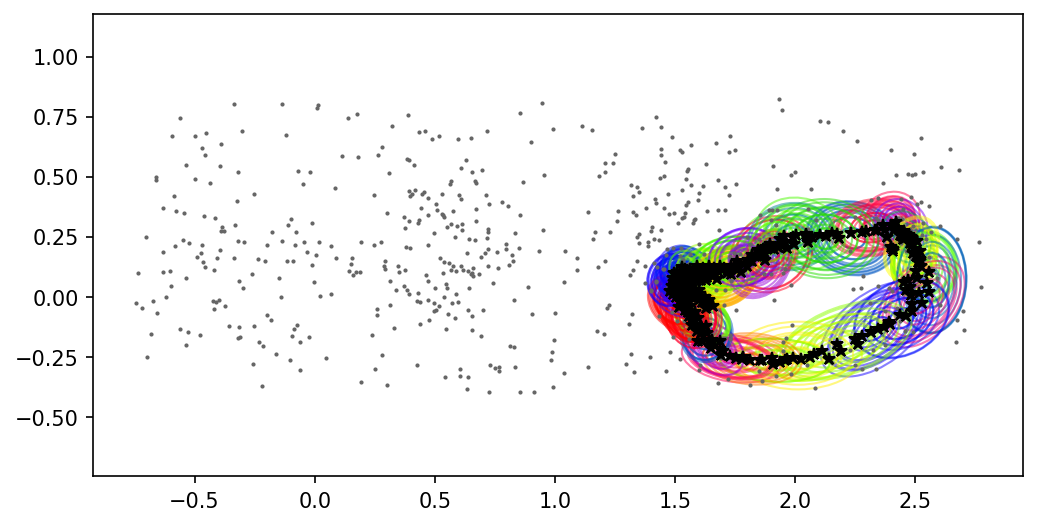

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
ax.plot(*data, 'o', markersize=1, color=(0.4, 0.4, 0.4))
ax.set_aspect('equal', adjustable='datalim')
cmap = plt.get_cmap('prism')  # 'viridis', 'Set1', 'tab20' など他のカラーマップも利用可能

for i0, i1 in combinations(optimal_1_cycle.boundary_points(), 2):
    e0, e1 = allobjs[i0], allobjs[i1]
    intersect_t, intersect, intersect_mu = colliders[int(i0), int(i1)]
    s = 3 * (0.333 + (1 - numpy.tanh(0.2*intersect_t)**2))
    if intersect_t > bd.birth + 1:
        continue

    c0 = cmap(i0 % cmap.N)
    ell = ellipse_patch(*e0[1], cov=e0[2], scale=intersect_t)
    ell.set(edgecolor=c0, alpha=0.5)
    ax.add_patch(ell)

    c1 = cmap(i1 % cmap.N)
    ell = ellipse_patch(*e1[1], cov=e1[2], scale=intersect_t)
    ell.set(edgecolor=c1, alpha=0.5)
    ax.add_patch(ell)

    ax.plot(*intersect, 'k*', markersize=6)

In [21]:
from sklearn import manifold

md_scaling = manifold.MDS(
    n_components=3,
    max_iter=max_iter,
    dissimilarity='precomputed'
)
X_mds = md_scaling.fit_transform(dist)

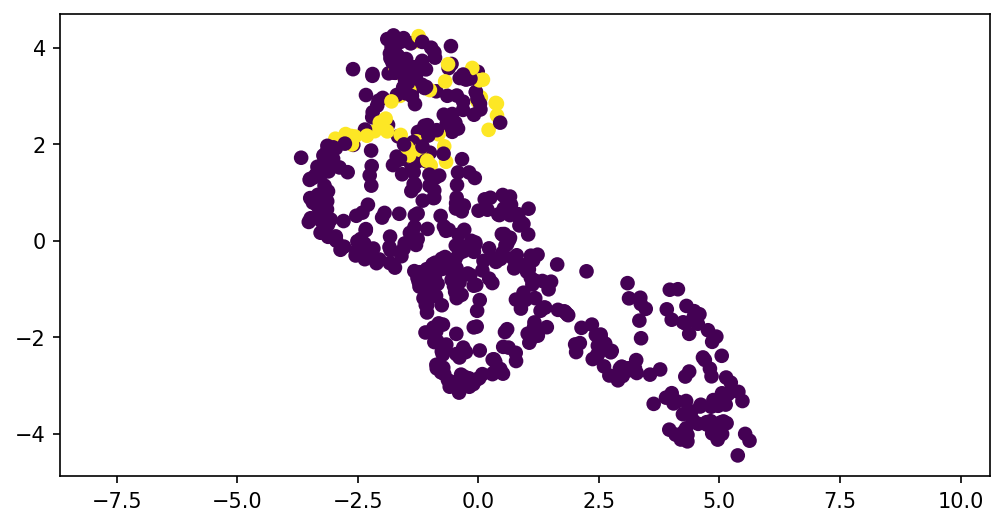

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)

bd = set(optimal_1_cycle.boundary_points())
color = [int(i in bd) for i in range(X_mds.shape[0])]
ax.scatter(*X_mds[:, :2].T[::-1], c=color)
ax.set_aspect('equal', adjustable='datalim')

In [23]:
fig = go.Figure(data=[
    go.Scatter3d(
        x=X_mds[:, 0],
        y=X_mds[:, 1],
        z=X_mds[:, 2],
        marker=dict(size=3, colorscale='Viridis', color=color, opacity=0.8),
        mode='markers'
    )
])
iplot(fig)

In [24]:
md_scaling = manifold.MDS(
    n_components=3,
    max_iter=max_iter,
    dissimilarity='precomputed'
)
Y_mds = md_scaling.fit_transform(squareform(pdist(data.T)))

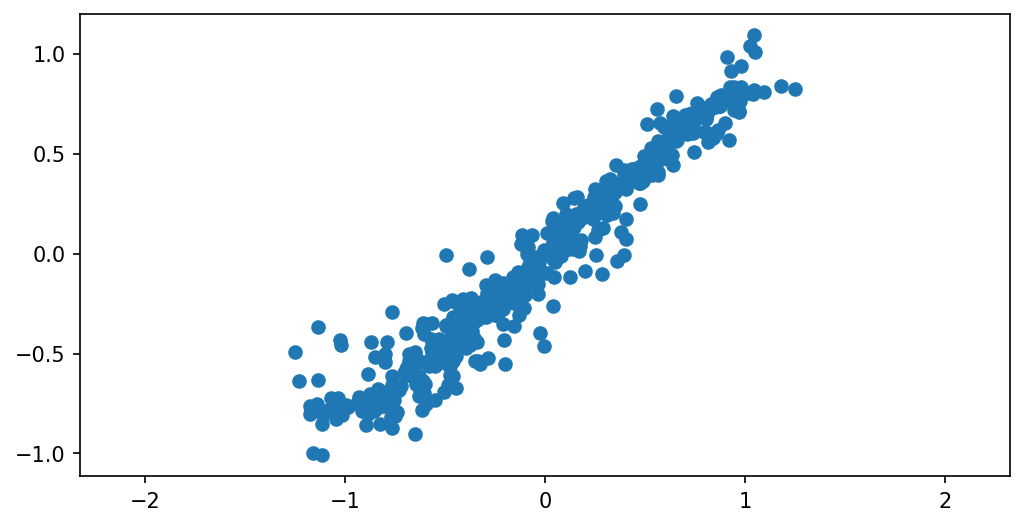

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
ax.scatter(*Y_mds[:, :2].T[::-1])
ax.set_aspect('equal', adjustable='datalim')

In [26]:
fig = go.Figure(data=[
    go.Scatter3d(
        x=Y_mds[:, 0],
        y=Y_mds[:, 1],
        z=Y_mds[:, 2],
        marker=dict(size=3, colorscale='Viridis', opacity=0.8),
        mode='markers'
    )
])
iplot(fig)

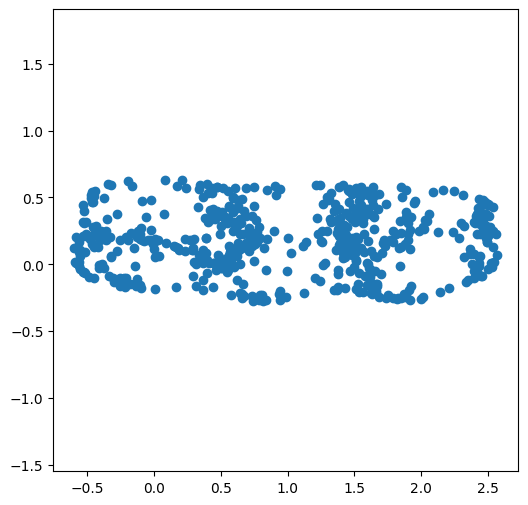

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# 中心点（＝幾何平均）のみプロット
center_points = np.mean(data[:, unique_subsets], axis=2)
ax.scatter(*center_points)
ax.set_aspect('equal', adjustable='datalim')

In [28]:
tsne_scaling = manifold.TSNE(
    n_components=3,
    max_iter=max_iter,
    init='random',
    metric='precomputed',
    method='exact'
)
Z_tsne = tsne_scaling.fit_transform(dist)
fig = go.Figure(data=[
    go.Scatter3d(
        x=Z_tsne[:, 0],
        y=Z_tsne[:, 1],
        z=Z_tsne[:, 2],
        marker=dict(size=6, colorscale='Viridis', opacity=0.8, color=center_points[0, :]),
        mode='markers'
    )
])
fig.update_layout(width=1000, height=1000)
iplot(fig)

In [29]:
tsne_scaling = manifold.TSNE(
    n_components=3,
    max_iter=max_iter,
    init='random',
    method='exact',
    metric='precomputed'
)
W_tsne = tsne_scaling.fit_transform(dist_orig)
fig = go.Figure(data=[
    go.Scatter3d(
        x=W_tsne[:, 0],
        y=W_tsne[:, 1],
        z=W_tsne[:, 2],
        marker=dict(size=6, colorscale='Viridis', opacity=0.8, color=data[0, :]),
        mode='markers'
    )
])
fig.update_layout(width=1000, height=1000)
iplot(fig)

In [30]:
import scipy.linalg as la

def bures_wasserstein_distance(Sigma1, Sigma2):
    """
    Bures-Wasserstein 距離 d_{BW}(\Sigma1, \Sigma2) を計算する。
    ここではいずれも対称正定 (SPD) 行列を仮定。
    
    d_{BW}^2(\Sigma1, Sigma2) = trace(Sigma1) + trace(Sigma2)
                                - 2 * trace( (Sigma1^(1/2) * Sigma2 * Sigma1^(1/2))^(1/2) ).
    d_{BW} はその平方根。
    """
    # SPD行列の平方根を計算
    sqrt_Sigma1 = la.sqrtm(Sigma1)
    
    # 中間行列 (Sigma1^(1/2) * Sigma2 * Sigma1^(1/2))^(1/2)
    prod = sqrt_Sigma1 @ Sigma2 @ sqrt_Sigma1
    sqrt_prod = la.sqrtm(prod)
    
    # トレースを計算
    # ※ 数値誤差で負にならないように max(..., 0) をとる
    trace_term = np.trace(Sigma1 + Sigma2 - 2*sqrt_prod)
    trace_term = max(trace_term, 0.0)
    
    return np.sqrt(trace_term)

In [31]:
def expm_at_Sigma(Sigma, X):
    """
    Bures–Wasserstein 計量での指数写像 Exp_{Sigma}(X).
    Sigma: SPD行列
    X: Sigma の接空間上の対称行列
    """
    # Sigma^(1/2)
    sqrt_Sigma = la.sqrtm(Sigma)
    # 中間行列
    M = sqrt_Sigma @ X @ sqrt_Sigma
    # 行列指数の計算 (複素成分をケアするには後述の射影が必要かも)
    expM = la.expm(M)
    # 戻す
    return sqrt_Sigma @ expM @ sqrt_Sigma

def logm_at_Sigma(Sigma, Gamma):
    """
    Bures–Wasserstein 計量での対数写像 Log_{Sigma}(Gamma).
    Sigma, Gamma: SPD行列
    """
    sqrt_Sigma = la.sqrtm(Sigma)
    invsqrt_Sigma = la.inv(sqrt_Sigma)
    # 中間行列
    M = invsqrt_Sigma @ Gamma @ invsqrt_Sigma
    # 行列対数
    logM = la.logm(M)
    return sqrt_Sigma @ logM @ sqrt_Sigma

def project_to_SPD(A, eps=0.0):
    """
    数値誤差などで SPD からずれている行列 A を
    固有値分解して負固有値をクリップし，再度 SPD 化する。
    eps > 0 で正の固有値下限を与えることもできる。
    """
    # 対称化 (虚数除去・転置平均)
    A_sym = 0.5 * (A + A.T)
    w, v = np.linalg.eigh(A_sym)
    w_clipped = np.clip(w, eps, None)  # 負を 0 (or eps) にクリップ
    return (v * w_clipped) @ v.T

In [32]:
def approx_BW_mean(sigma1, sigma2, alpha=0.5):
    return expm_at_Sigma(sigma1, alpha * logm_at_Sigma(sigma1, sigma2))

def iterative_approx_BW_barycenter(sigma_list, max_iter=20, tol=1.0e-3, alpha=0.5, log=False):
    sigmas = list(sigma_list)
    n = len(sigmas)
    norm0 = sum(la.norm(sigmas[i], 'fro') for i in range(n))
    # 最後に sigmas[0] を加えておき円順序で最後にこれが参照されるように
    sigmas.append(sigmas[0])
    for t in range(max_iter):
        for i in range(n):
            # i 番目はもう使われないので逐次更新
            sigmas[i] = approx_BW_mean(sigmas[i], sigmas[i + 1], alpha=alpha)
        sigmas[n] = sigmas[0] # n 番目が使われたので次のループ用に 0 番にセット
        norm = sum(
            la.norm(sigmas[i] - sigmas[i + 1], 'fro')
            for i in range(n)
        )
        if norm < tol * norm0:
            break
        if log and (t % 10 == 0):
            loss = sum(
                bures_wasserstein_distance(sigmas[0], sigma_list[i])**2
                for i in range(n)
            )
            print(loss)
    return sigmas[0]

def BW_barycenter(Sigma_list, alpha=1.0e-1, max_iter=1000, tol=1e-4, log=False):
    """
    Bures–Wasserstein Fréchet 平均を 勾配降下(Karcher流) で求める簡易実装。

    Parameters
    ----------
    Sigma_list: list of np.ndarray
        各要素は対象正定行列 (SPD)
    alpha: float
        ステップサイズ (0 < alpha <= 1 くらい)
    max_iter: int
        最大反復回数
    tol: float
        収束閾値 (フロベニウスノルム)
    """
    k = len(Sigma_list)
    n = Sigma_list[0].shape[0]

    # 初期値: 反復法でなるべく近い初期値を与える
    Sigma = iterative_approx_BW_barycenter(Sigma_list, max_iter=5, log=False)

    for t in range(max_iter):
        # 勾配 = sum_i Log_{Sigma}(Sigma_i)
        G = np.zeros((n, n), dtype=float)
        for S in Sigma_list:
            G += logm_at_Sigma(Sigma, S)
        # 平均化するなら (1/k) を掛けることもあるが，ここではそのままでもOK
        G /= k  # 場合によっては入れる

        # 勾配方向へ alpha だけ移動 => Exp_{Sigma}(- alpha * G)
        # (min化なので負勾配方向)
        H = alpha * G
        Sigma_new = expm_at_Sigma(Sigma, H)

        # # 数値誤差でSPDでなくなる可能性をケア
        # Sigma_new = project_to_SPD(Sigma_new)

        # 収束チェック
        diff = np.linalg.norm(Sigma_new - Sigma, 'fro')
        Sigma = Sigma_new
        if diff < tol:
            break
        if log and (t % 10 == 0):
            loss = sum(
                bures_wasserstein_distance(Sigma, Sigma_list[i])**2
                for i in range(n)
            )
            print(loss)

    return project_to_SPD(Sigma)

In [33]:
covs = np.zeros((unique_subsets.shape[0], 2, 2))
inverse_table = [[] for _ in range(data.shape[1])]

for k, near_indices in enumerate(unique_subsets):
    near_data = data[:, near_indices]
    covs[k] = np.cov(near_data)
    for i in near_indices:
        inverse_table[i].append(k)

covs.shape, data.shape, unique_subsets.shape

((564, 2, 2), (2, 600), (564, 25))

In [34]:
cov_barycenters = []
for indices in inverse_table:
    if len(indices) == 1:
        cov_barycenters.append(covs[indices[0]])
    else:
        bary = BW_barycenter(covs[indices], alpha=0.2, max_iter=100)
        cov_barycenters.append(bary)

cov_barycenters

[array([[0.01143962, 0.00033236],
        [0.00033236, 0.01241687]]),
 array([[0.01143963, 0.00033234],
        [0.00033234, 0.01241685]]),
 array([[0.01143959, 0.00033236],
        [0.00033236, 0.01241681]]),
 array([[0.01342766, 0.00088837],
        [0.00088837, 0.00983516]]),
 array([[0.01143963, 0.00033235],
        [0.00033235, 0.01241683]]),
 array([[0.01699613, 0.00061828],
        [0.00061828, 0.01455414]]),
 array([[0.01143959, 0.00033233],
        [0.00033233, 0.01241687]]),
 array([[0.04454429, 0.00012235],
        [0.00012235, 0.01369569]]),
 array([[ 0.01249355, -0.00223593],
        [-0.00223593,  0.00614891]]),
 array([[ 0.00888121, -0.00053275],
        [-0.00053275,  0.00913717]]),
 array([[ 0.01483628, -0.00057544],
        [-0.00057544,  0.00531624]]),
 array([[ 0.01135999, -0.00308078],
        [-0.00308078,  0.00750079]]),
 array([[0.01698861, 0.00061396],
        [0.00061396, 0.01455111]]),
 array([[0.04453169, 0.00012212],
        [0.00012212, 0.01369537]]),
 arr

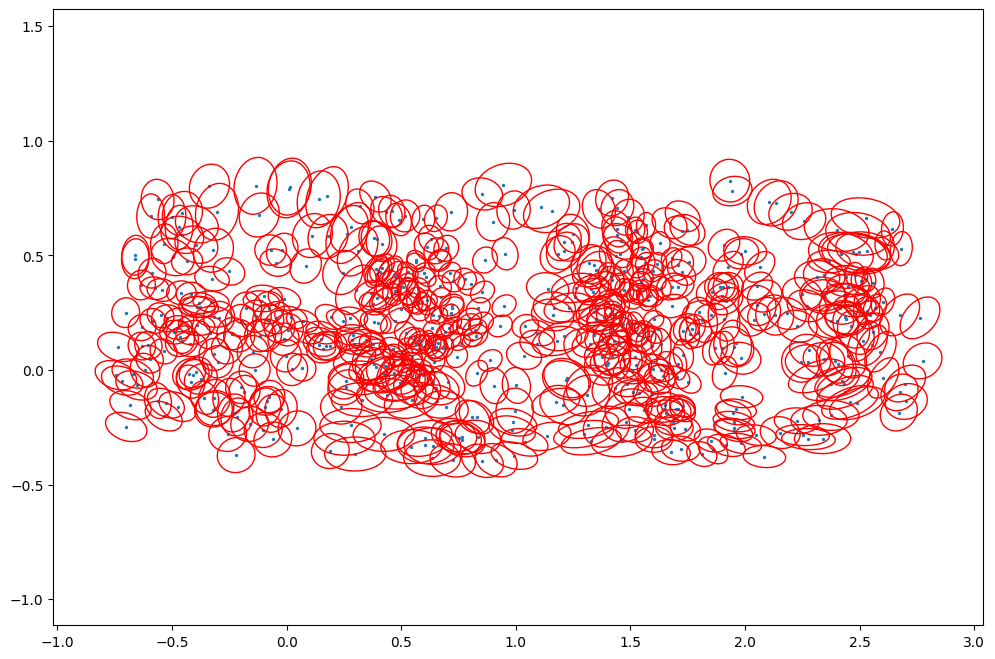

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(*data, s=2, marker='o')
ax.set_aspect('equal', adjustable='datalim')

ellipses2 = []

for i in range(data.shape[1]):
    cov = cov_barycenters[i]
    center = data[:, i]
    e = abcdef_from_cov(*center, cov)
    ellipses2.append((e, center, cov))
    p = ellipse_patch(*center, cov=cov*0.4)
    p.set(edgecolor='red')
    ax.add_patch(p)

In [36]:
num_ell2 = len(ellipses2)
dist2 = np.zeros((num_ell2, num_ell2))
colliders2 = {}
for (i0, e0), (i1, e1) in combinations(enumerate(ellipses2), 2):
    try:
        colliders2[i0, i1] = colliders2[i1, i0] = find_intersect(e0[0], e1[0])
        dist2[i0, i1] = dist2[i1, i0] = colliders2[i0, i1][0]
    except Exception as e:
        print(i0, i1)
        print(e0)
        print(e1)
        print(numpy.array(e0) - numpy.array(e1))

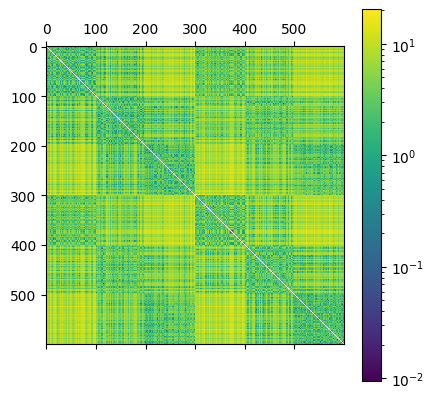

In [37]:
plt.matshow(dist2, norm='log')
plt.colorbar()

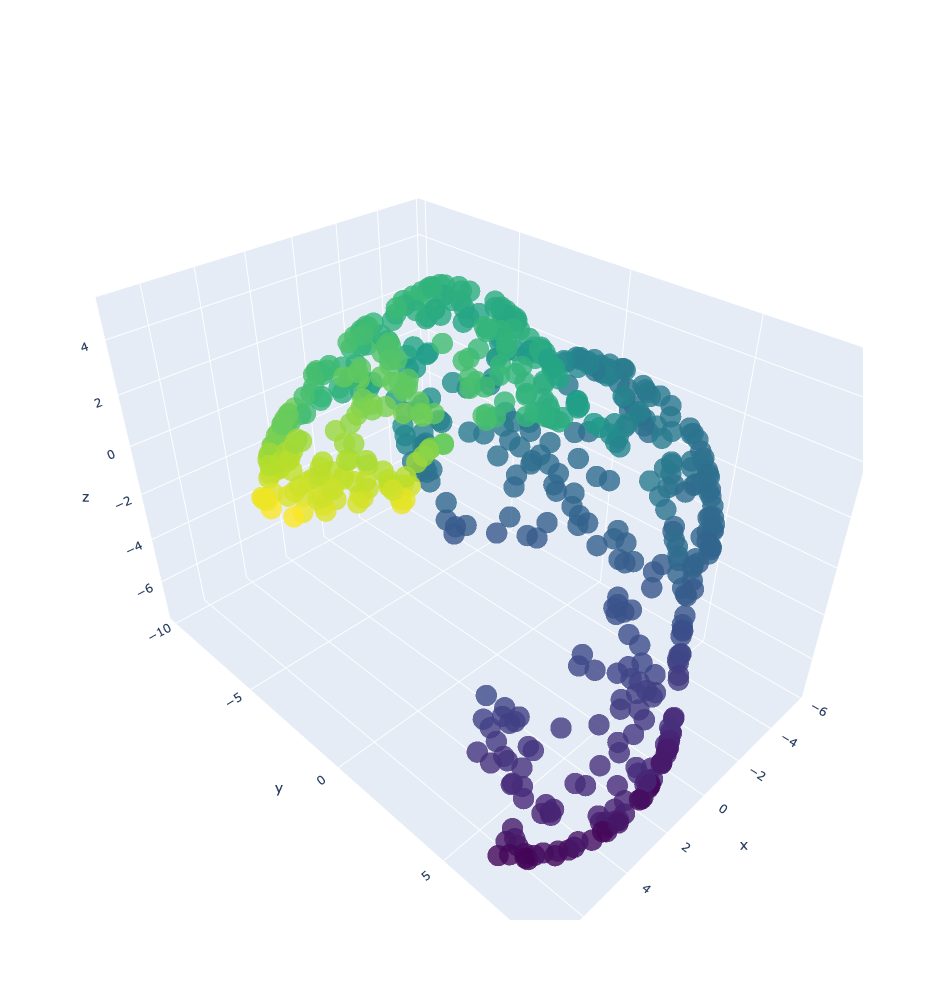

In [38]:
tsne_scaling = manifold.TSNE(
    n_components=3,
    max_iter=max_iter,
    init='random',
    metric='precomputed',
    method='exact'
)
Z_tsne_2 = tsne_scaling.fit_transform(dist2)
fig = go.Figure(data=[
    go.Scatter3d(
        x=Z_tsne_2[:, 0],
        y=Z_tsne_2[:, 1],
        z=Z_tsne_2[:, 2],
        marker=dict(size=6, colorscale='Viridis', opacity=0.8, color=data[0, :]),
        mode='markers'
    )
])
fig.update_layout(width=1000, height=1000)
iplot(fig)

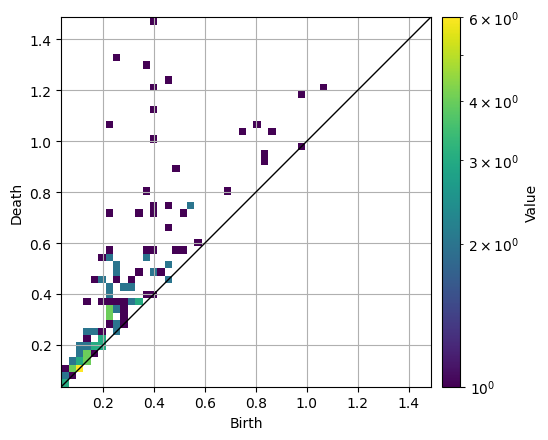

In [39]:
hc.PDList.from_rips_filtration(dist2, maxdim=2, save_to="rips.pdgm", save_graph=True)
pdlist = hc.PDList("rips.pdgm")
pd1 = pdlist.dth_diagram(1)
pd1.histogram(x_bins=50).plot(**pd_hist_config)
plt.show()

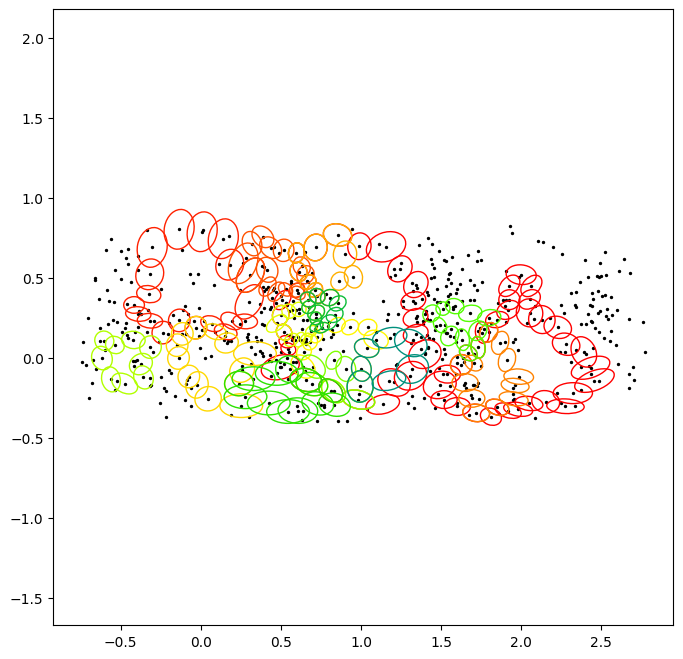

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(*data, s=2, marker='o', color='black')
ax.set_aspect('equal', adjustable='datalim')

take = 15
sorted_pairs = sorted(
    pd1.pairs(), reverse=True,
    key=lambda p: p.death_time() - p.birth_time())
for bd, color in zip(sorted_pairs[:take], cmap(numpy.arange(take))):
    opt1_cycle = bd.optimal_1_cycle()
    for near_indices in opt1_cycle.boundary_points():
        center, cov = ellipses2[near_indices][1:]
        p = ellipse_patch(*center, cov=cov*0.4)
        p.set(edgecolor=color)
        ax.add_patch(p)    